In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess
from tqdm import tqdm_notebook
import pprint
import librosa
import yaml
from IPython.display import clear_output
from multiprocessing import Pool

import music21
import madmom

In [35]:
SAMPLING_FREQUENCY = 22050
FRAME_SIZE = 2048
FPS = 20

In [36]:
# path to MSMD dataset
DATA_ROOT_MSMD = '../msmd_aug/msmd_aug'

In [40]:
# obtain all the pieces in the dataset
with open('../msmd/msmd/splits/all_split.yaml', 'r') as f:
    doc = yaml.load(f)
    
pieces = doc['test']
assert len(pieces) == 100

In [41]:
def calcBin(f, R=100, base=0, base_ref=27.5):
    """
    Calculate the bin frequencies
    """
    return (np.round(1200 / R * np.log2(f/base_ref) + base)).astype(np.int)

In [42]:
def notes_to_onsets(notes, dt):
    """ Convert sequence of keys to onset frames """

    onsets = []
    for n in notes:
        onset = int(np.ceil(n[0] / dt))
        onsets.append(onset)

    return np.sort(np.asarray(onsets)).astype(np.float32)

In [47]:
def generateSpec(piece_idx, debug=False):
    sig_proc = madmom.audio.signal.SignalProcessor(sample_rate=SAMPLING_FREQUENCY, num_channels=1)
    fsig_proc = madmom.audio.signal.FramedSignalProcessor(frame_size=FRAME_SIZE, fps=FPS, origin='future')
    spec_proc = madmom.audio.spectrogram.SpectrogramProcessor()
    
    piece = pieces[piece_idx]
    performances = glob.glob(os.path.join(DATA_ROOT_MSMD, piece, 'performances', '*'))
    for performance in performances:
        if not performance.endswith('tempo-1000_grand-piano-YDP-20160804'): continue
        
        if debug:
            print(performance)
        
        audio_file = glob.glob(os.path.join(performance, 'audio', '*.flac'))[0]
        midi_file = glob.glob(os.path.join(performance, '*.midi'))[0]

        # Compute salience representation
        sig = sig_proc(audio_file)
        sig = fsig_proc(sig)
        spec = spec_proc(sig)

        n_frames = spec.shape[0]
        salience = np.zeros((88, n_frames))

        fk = np.arange(spec.shape[1]) / FRAME_SIZE * SAMPLING_FREQUENCY
        dft_indices = calcBin(fk)
        for k in range(88):
            salience[k, :] = np.sum(spec.T[dft_indices == k,:], axis=0)

        if not os.path.exists(os.path.join(performance, 'spec')):
            os.mkdir(os.path.join(performance, 'spec'))

        spec_file_path = os.path.join(performance, 'spec', os.path.basename(performance)) + '_spec.npy'
        np.save(spec_file_path, salience)
        
        if debug:
            plt.imshow(salience, aspect='auto', cmap='hot')
            plt.show()
            

        # Compute onset
        s = music21.midi.translate.midiFilePathToStream(midi_file)
        mf = music21.midi.translate.streamToMidiFile(s)
        n_tracks = len(mf.tracks)

        onsets = None
        for i_track, track in enumerate(mf.tracks[0:1]):
            m = madmom.utils.midi.MIDIFile.from_file(midi_file)

            notes =  np.asarray(sorted(m.notes(), key=lambda n: (n[0], n[1] * -1)))
            onsets = notes_to_onsets(notes, dt=1.0/FPS)

        onsets_file_path = os.path.join(performance, 'spec', os.path.basename(performance)) + '_onsets.npy'
        np.save(onsets_file_path, onsets)

In [50]:
with Pool(12) as p:
    list(tqdm_notebook(p.imap(generateSpec, range(len(pieces))), total=len(pieces)))

HBox(children=(IntProgress(value=0), HTML(value='')))

../msmd_aug/msmd_aug/MozartWA__KV331__KV331_1_2_var1/performances/MozartWA__KV331__KV331_1_2_var1_tempo-1000_grand-piano-YDP-20160804


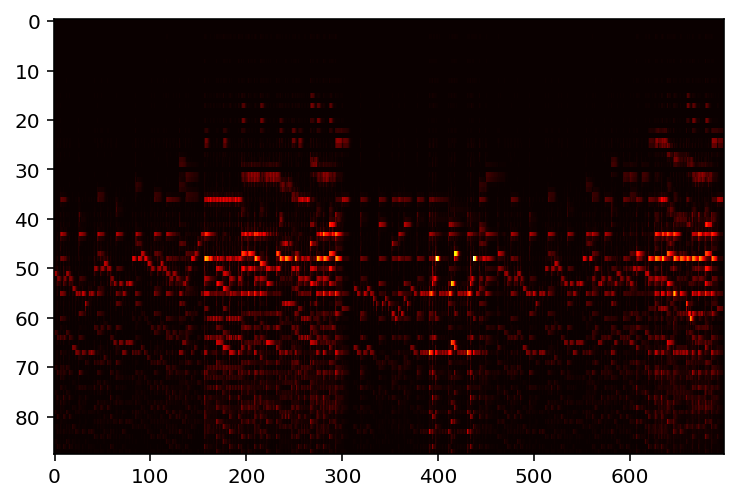

In [49]:
generateSpec(2, debug=True)